In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
!pip install tensorflow


In [1]:
import os
import random
from shutil import copy2
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from PIL import Image



In [3]:
dataset_dir = '/content/drive/MyDrive/dataset'
train_dir = '/content/drive/MyDrive/weed_dataset_split/train'
test_dir = '/content/drive/MyDrive/weed_dataset_split/test'
for folder in [train_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)
split_ratio = 0.8
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    image_paths = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(image_paths)
    train_split = int(len(image_paths) * split_ratio)
    train_images = image_paths[:train_split]
    test_images = image_paths[train_split:]
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
    for img in tqdm(train_images, desc=f"Copying {class_name} - Train"):
        copy2(img, os.path.join(train_dir, class_name))
    for img in tqdm(test_images, desc=f"Copying {class_name} - Test"):
        copy2(img, os.path.join(test_dir, class_name))


Copying W_CL_07_Marsilea minuta - Test: 100%|██████████| 76/76 [00:00<00:00, 79.50it/s]


In [4]:
target_count = 1500
augmented_dir = '/content/drive/MyDrive/weed_dataset_split/augmented'
os.makedirs(augmented_dir, exist_ok=True)
datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
for class_name in os.listdir(train_dir):
    class_train_dir = os.path.join(train_dir, class_name)
    augmented_class_dir = os.path.join(augmented_dir, class_name)
    os.makedirs(augmented_class_dir, exist_ok=True)
    images = [os.path.join(class_train_dir, img) for img in os.listdir(class_train_dir)]
    num_images = len(images)
    image_array = [np.array(Image.open(img).resize((150, 150))) for img in images]
    i = 0
    while num_images + i < target_count:
        img = np.expand_dims(image_array[i % len(image_array)], axis=0)
        for batch in datagen.flow(img, batch_size=1, save_to_dir=augmented_class_dir, save_prefix='aug', save_format='jpeg'):
            i += 1
            if num_images + i >= target_count:
                break


In [5]:
train_data_dir = augmented_dir
test_data_dir = test_dir
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')
test_generator = test_datagen.flow_from_directory(test_data_dir, target_size=(150, 150), batch_size=32, class_mode='categorical')


Found 6207 images belonging to 6 classes.
Found 618 images belonging to 6 classes.


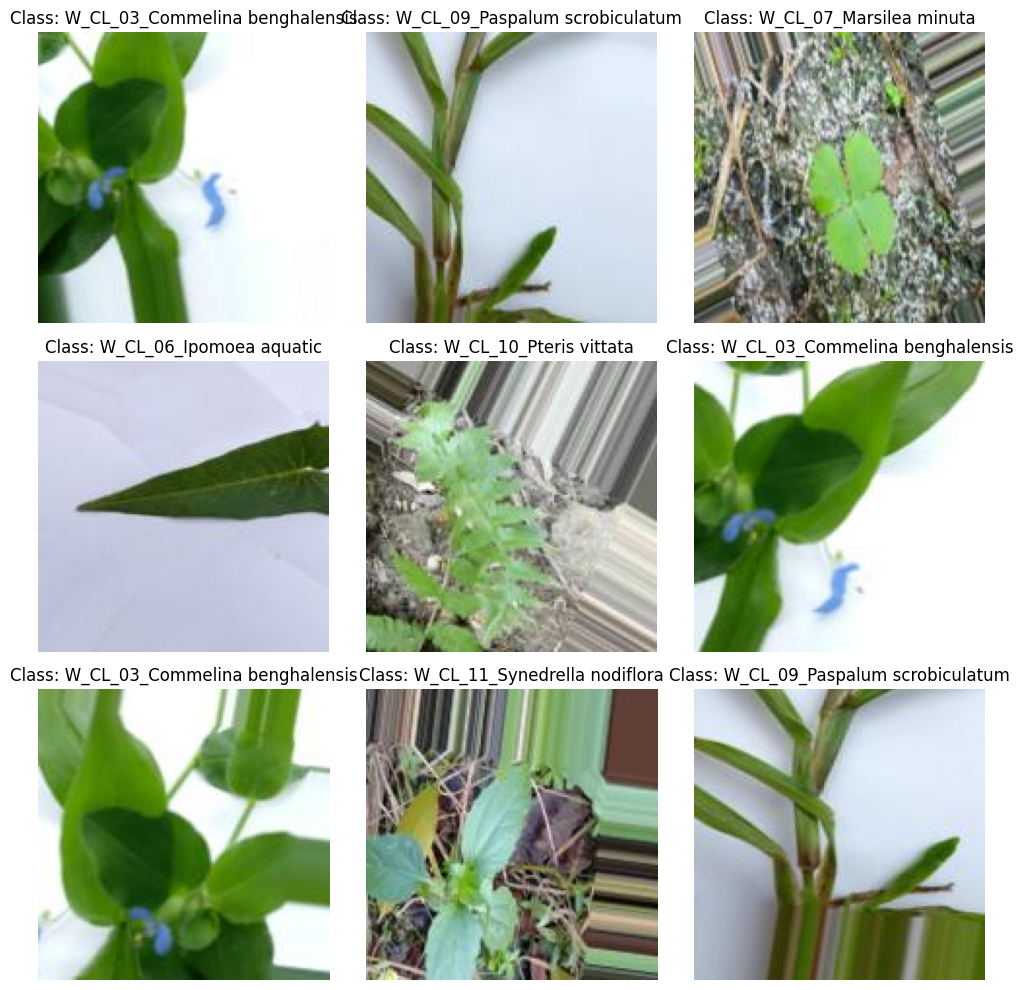

In [6]:
def visualize_sample_images(generator):
    sample_batch, sample_labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(sample_batch[i])
        plt.title(f"Class: {list(generator.class_indices.keys())[np.argmax(sample_labels[i])]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_sample_images(train_generator)

In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


194/194 ━━━━━━━━━━━━━━━━━━━━ 39s 166ms/step - accuracy: 0.7034 - loss: 0.9442 - val_accuracy: 0.2492 - val_loss: 10.3752
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - accuracy: 0.9955 - loss: 0.0187 - val_accuracy: 0.2783 - val_loss: 9.7621
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - accuracy: 0.9947 - loss: 0.0173 - val_accuracy: 0.2411 - val_loss: 13.5157
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - accuracy: 0.9973 - loss: 0.0088 - val_accuracy: 0.2557 - val_loss: 15.4016
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - accuracy: 0.9945 - loss: 0.0180 - val_accuracy: 0.2767 - val_loss: 15.7624
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 27s 134ms/step - accuracy: 0.9958 - loss: 0.0141 - val_accuracy: 0.2751 - val_loss: 14.6573
Epoch 7/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 27s 133ms/step - accuracy: 0.9993 - loss: 0.0024 - val_accuracy: 0.2330 - val_loss: 17.9365
Epoch 8/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 26s 132ms/step - accuracy: 0.9915 - loss: 0.0242

In [10]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 189ms/step - accuracy: 0.2576 - loss: 24.8933
Test Accuracy: 25.57%


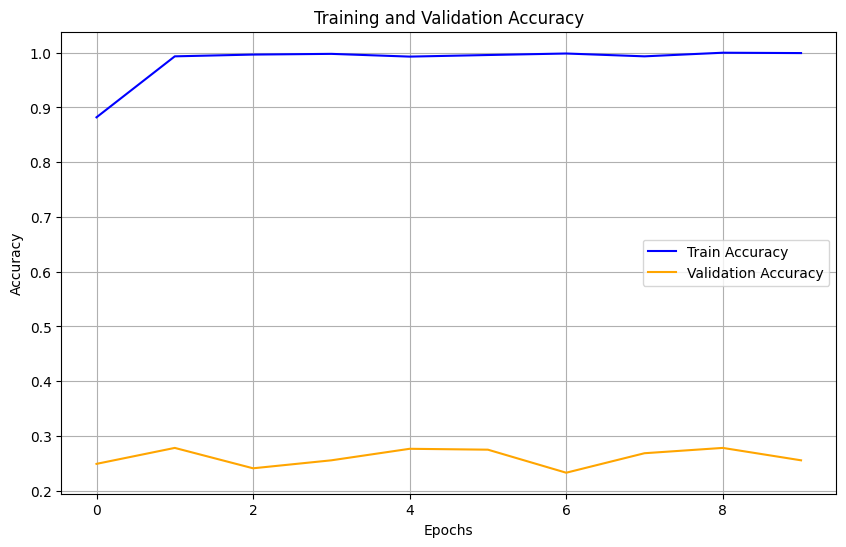

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


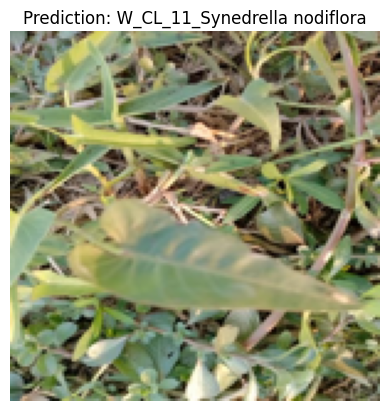

In [13]:
def predict_new_image(model, img_path, class_indices):
    img = Image.open(img_path).resize((150, 150))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    predicted_class = list(class_indices.keys())[np.argmax(predictions)]
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis("off")
    plt.show()

class_indices = train_generator.class_indices
predict_new_image(model, '/content/drive/MyDrive/weed_dataset_split/test/W_CL_06_Ipomoea aquatic/6_20221210_0003.jpg', class_indices)

In [2]:
import os
import random
from shutil import copy2
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image

In [3]:
dataset_dir = '/content/drive/MyDrive/dataset_new'
train_dir = '/content/drive/MyDrive/new_weed_dataset_split/train'
test_dir = '/content/drive/MyDrive/new_weed_dataset_split/test'

split_ratio = 0.8
for folder in [train_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    image_paths = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(image_paths)
    train_split = int(len(image_paths) * split_ratio)
    train_images = image_paths[:train_split]
    test_images = image_paths[train_split:]
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
    for img in tqdm(train_images, desc=f"Copying {class_name} - Train"):
        copy2(img, os.path.join(train_dir, class_name))
    for img in tqdm(test_images, desc=f"Copying {class_name} - Test"):
        copy2(img, os.path.join(test_dir, class_name))


Copying W_CL_09_Paspalum scrobiculatum - Test: 100%|██████████| 78/78 [00:01<00:00, 75.54it/s]


In [4]:
target_count = 2000
augmented_dir = '/content/drive/MyDrive/new_weed_dataset_split/augmented'
os.makedirs(augmented_dir, exist_ok=True)

datagen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)

for class_name in os.listdir(train_dir):
    class_train_dir = os.path.join(train_dir, class_name)
    augmented_class_dir = os.path.join(augmented_dir, class_name)
    os.makedirs(augmented_class_dir, exist_ok=True)
    images = [os.path.join(class_train_dir, img) for img in os.listdir(class_train_dir)]
    num_images = len(images)
    image_array = [np.array(Image.open(img).resize((150, 150))) for img in images]
    i = 0
    while num_images + i < target_count:
        img = np.expand_dims(image_array[i % len(image_array)], axis=0)
        for batch in datagen.flow(img, batch_size=1, save_to_dir=augmented_class_dir, save_prefix='aug', save_format='jpeg'):
            i += 1
            if num_images + i >= target_count:
                break


In [5]:
train_data_dir = augmented_dir
test_data_dir = test_dir

train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir, target_size=(150, 150), batch_size=32, class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_data_dir, target_size=(150, 150), batch_size=32, class_mode='categorical'
)


Found 9363 images belonging to 6 classes.
Found 464 images belonging to 6 classes.


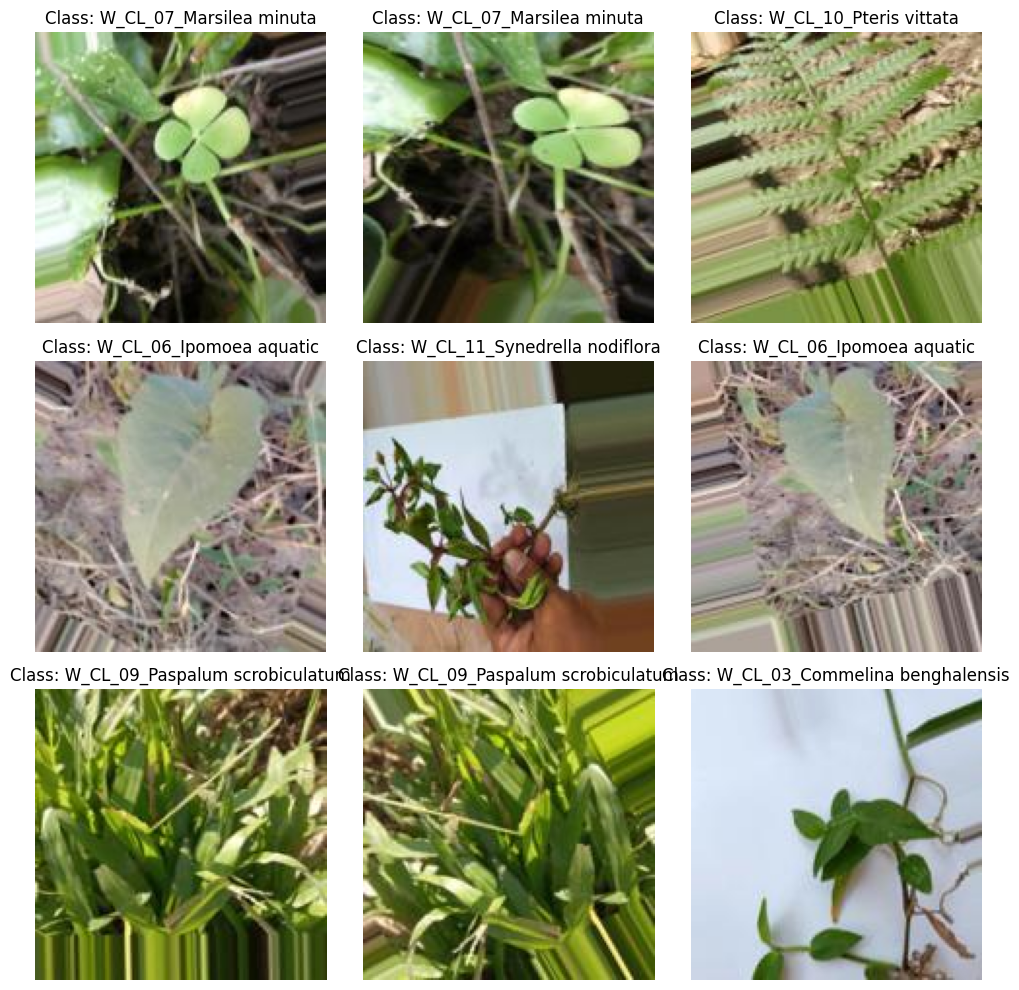

In [6]:
def visualize_sample_images(generator):
    sample_batch, sample_labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(sample_batch[i])
        plt.title(f"Class: {list(generator.class_indices.keys())[np.argmax(sample_labels[i])]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

visualize_sample_images(train_generator)


In [7]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

base_model.trainable = False
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, epochs=20, validation_data=test_generator)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


293/293 ━━━━━━━━━━━━━━━━━━━━ 61s 168ms/step - accuracy: 0.8712 - loss: 0.4363 - val_accuracy: 0.4483 - val_loss: 2.3112
Epoch 2/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 37s 125ms/step - accuracy: 1.0000 - loss: 0.0082 - val_accuracy: 0.4504 - val_loss: 2.6057
Epoch 3/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 38s 128ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.4526 - val_loss: 2.7980
Epoch 4/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 42s 132ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.4504 - val_loss: 2.9173
Epoch 5/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 39s 131ms/step - accuracy: 0.9999 - loss: 0.0015 - val_accuracy: 0.4547 - val_loss: 3.0683
Epoch 6/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 41s 132ms/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 0.4569 - val_loss: 3.2309
Epoch 7/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 41s 136ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.4504 - val_loss: 3.3491
Epoch 8/20
293/293 ━━━━━━━━━━━━━━━━━━━━ 38s 127ms/step - accuracy: 1.0000 - loss: 7.4056e-04 -

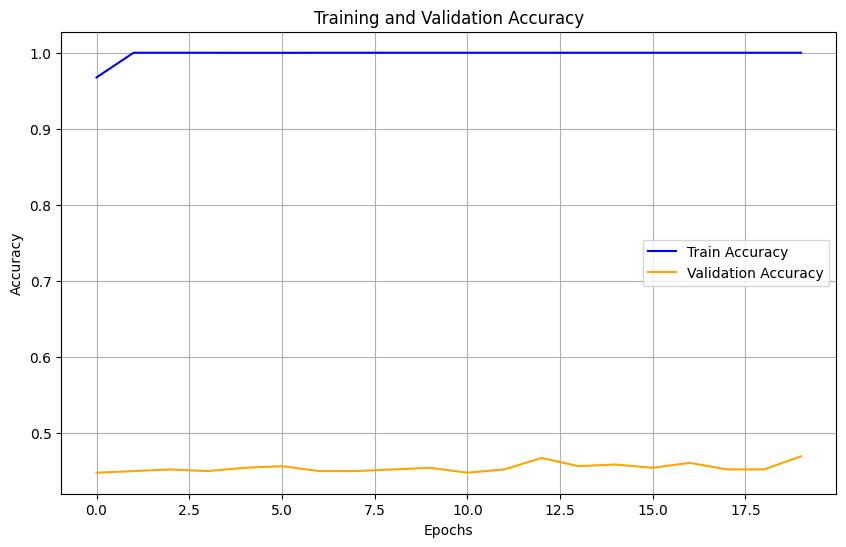

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.4620 - loss: 4.1965
Test Accuracy: 46.98%


15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 496ms/step


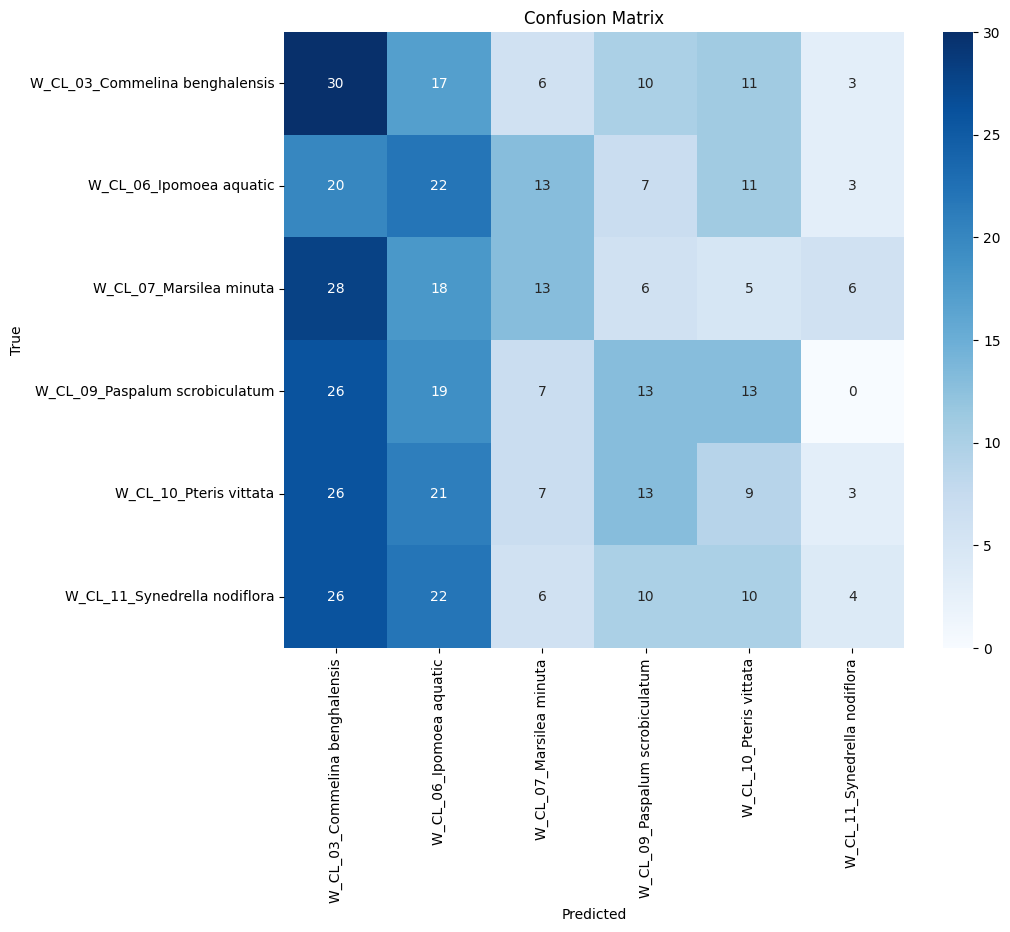

                                precision    recall  f1-score   support

W_CL_03_Commelina benghalensis       0.19      0.39      0.26        77
       W_CL_06_Ipomoea aquatic       0.18      0.29      0.23        76
       W_CL_07_Marsilea minuta       0.25      0.17      0.20        76
W_CL_09_Paspalum scrobiculatum       0.22      0.17      0.19        78
        W_CL_10_Pteris vittata       0.15      0.11      0.13        79
  W_CL_11_Synedrella nodiflora       0.21      0.05      0.08        78

                      accuracy                           0.20       464
                     macro avg       0.20      0.20      0.18       464
                  weighted avg       0.20      0.20      0.18       464



In [10]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(true_classes, predicted_classes, target_names=class_labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


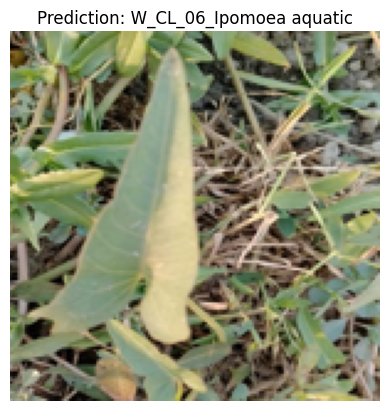

In [13]:
def predict_new_image(model, img_path, class_indices):
    img = Image.open(img_path).resize((150, 150))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    predicted_class = list(class_indices.keys())[np.argmax(predictions)]
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis("off")
    plt.show()

class_indices = train_generator.class_indices
predict_new_image(model, '/content/drive/MyDrive/new_weed_dataset_split/test/W_CL_06_Ipomoea aquatic/6_20221210_0014.jpg', class_indices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


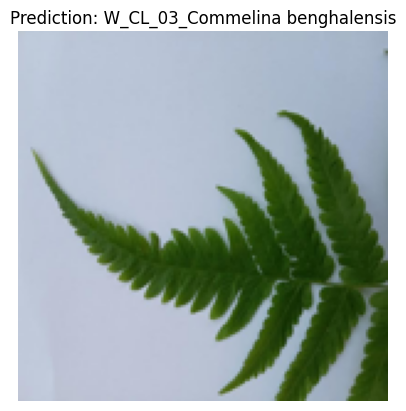

In [14]:
def predict_new_image(model, img_path, class_indices):
    img = Image.open(img_path).resize((150, 150))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    predicted_class = list(class_indices.keys())[np.argmax(predictions)]
    plt.imshow(img)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis("off")
    plt.show()

class_indices = train_generator.class_indices
predict_new_image(model, '/content/drive/MyDrive/new_weed_dataset_split/test/W_CL_10_Pteris vittata/10_20221202_0020.jpg', class_indices)
